# Part 1 - Transfer Learning

## 1.0 Packages

### 1.1 Loading the Packages used for the model.

In [1]:
# Data packages
import pandas as pd
import numpy as np

# Image manipulation
from PIL import Image

# Other system packages
import os

# Keras functions 
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.applications import resnet50
# from keras.datasets import mnist

# sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# fashion mnist dataset
from keras.datasets import fashion_mnist

Using TensorFlow backend.


## 2.0 Data Processing

### 2.1 Create the module to standardise dataset.

Notes:

- RGB (Red, Green, Blue) are 8 bit each.
- The range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
- The combination range is 256 * 256 * 256.
- By dividing by 255, the 0-255 range can be described with a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).

In [2]:
def standarise_data(dataset):
    
    new_dataset = dataset/255.
    
    return new_dataset

### 2.2 Create the load_data module to load the fashion mnist dataset.

- Uses Fashion-MNIST database of fashion articles from Keras.

    Dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 
    This dataset can be used as a drop-in replacement for MNIST. The class labels are:      
    
        Label | Description
        ---------------------
        0     | T-shirt/top
        1     | Trouser
        2     | Pullover
        3     | Dress
        4     | Coat    
        5     | Sandal
        6     | Shirt
        7     | Sneaker     
        8     | Bag 
        9     | Ankle boot

- The load_data module defines the X_train, X_test, y_train, y_test, X, y global variables.
      -- X_train - contains the input images to be used for training.
      -- y_train - the corresponding labels (classification) of the X_train dataset.
      -- X_test - contains the input images to be used for testing.
      -- y_test - the corresponding labels (classification) of the X_test dataset.
      
- Calls the standarise_data module to normalise the input datasets.

In [3]:
def load_data():
    global X_train, X_test, y_train, y_test, X, y

    ((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()

    # Standardize data to have feature values between 0 and 1.
    X_train = standarise_data(X_train)
    X_test = standarise_data(X_test)
    
    print ("Flatten X_train: " + str(X_train.shape))
    print ("Flatten X_test: " + str(X_test.shape))
    
    print ("y_train: " + str(y_train.shape))
    print ("y_test: " + str(y_test.shape))
    
    return

In [4]:
load_data()

Flatten X_train: (60000, 28, 28)
Flatten X_test: (10000, 28, 28)
y_train: (60000,)
y_test: (10000,)


In [5]:
# Checking how many labels are in the y dataset
# There are 10 labels as described above.
print(y_train)
unique = np.unique(y_train, return_counts=False)
print (unique)

[9 0 0 ... 3 0 5]
[0 1 2 3 4 5 6 7 8 9]


In [6]:
# Convert class vectors to binary class matrices
# Note we will save y_test for our sklearn metrics
y_test_skl = y_test.copy()

y_train = keras.utils.to_categorical(y_train,10)
y_test = keras.utils.to_categorical(y_test,10)
print ("y_train: " + str(y_train.shape))
print ("y_test: " + str(y_test.shape))

print(y_train)
print(y_test_skl)


y_train: (60000, 10)
y_test: (10000, 10)
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[9 2 1 ... 8 1 5]


### 2.3 Input Processing (Training and Test dataset)

In [25]:
# Using only 2500 images as my computer does not allow more than 4Gb.
X_train_s1 = X_train[0:30000]
y_train_s1 = y_train[0:30000]

X_test_s1 = X_test[0:5000]
y_test_s1 = y_test[0:5000]


Notes: 
- Checking sample image from the selected sampling and checking the shape before resizing the input.

X_train shape: (30000, 28, 28)
y_train shape: (30000, 10)


([], <a list of 0 Text yticklabel objects>)

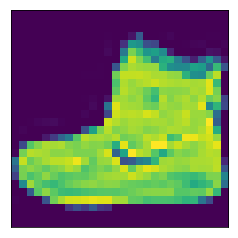

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

print("X_train shape: " + str(X_train_s1.shape))
print("y_train shape: " + str(y_train_s1.shape))
img_path = X_train[0]
plt.imshow(img_path)
plt.xticks([])
plt.yticks([])

X_test shape: (5000, 28, 28)
y_test shape: (5000, 10)


([], <a list of 0 Text yticklabel objects>)

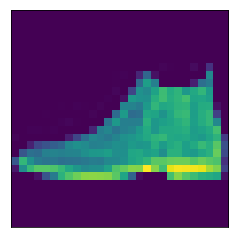

In [27]:
print("X_test shape: " + str(X_test_s1.shape))
print("y_test shape: " + str(y_test_s1.shape))

img_path = X_test[0]
plt.imshow(img_path)
plt.xticks([])
plt.yticks([])

### 2.4 Reshape training and test dataset.

Notes:
- Original image has a shape of (28 * 28).
- The images will be reshaped to fit the ResNet50 model which requires (224 * 224) shape.

#### 2.4.1 Reshape training dataset (X_train)

In [28]:
# We need to do some reshaping
import skimage.transform

X_train_reshape = []

count = 0

for image in X_train_s1:
    
    # Tracking how many images have been resized.
    count +=1 
    if count % 500 == 0:
        print("Done {} images".format(count))
        
    new_image = skimage.transform.resize(image, (32, 32,3), mode='constant')
    X_train_reshape.append(new_image)

Done 500 images
Done 1000 images
Done 1500 images
Done 2000 images
Done 2500 images
Done 3000 images
Done 3500 images
Done 4000 images
Done 4500 images
Done 5000 images
Done 5500 images
Done 6000 images
Done 6500 images
Done 7000 images
Done 7500 images
Done 8000 images
Done 8500 images
Done 9000 images
Done 9500 images
Done 10000 images
Done 10500 images
Done 11000 images
Done 11500 images
Done 12000 images
Done 12500 images
Done 13000 images
Done 13500 images
Done 14000 images
Done 14500 images
Done 15000 images
Done 15500 images
Done 16000 images
Done 16500 images
Done 17000 images
Done 17500 images
Done 18000 images
Done 18500 images
Done 19000 images
Done 19500 images
Done 20000 images
Done 20500 images
Done 21000 images
Done 21500 images
Done 22000 images
Done 22500 images
Done 23000 images
Done 23500 images
Done 24000 images
Done 24500 images
Done 25000 images
Done 25500 images
Done 26000 images
Done 26500 images
Done 27000 images
Done 27500 images
Done 28000 images
Done 28500 i

#### 2.4.2 Reshape testing dataset (X_test)

In [29]:
# Reshaping testing dataset
X_test_reshape = []

count = 0

for image in X_test_s1:
    
    # Tracking how many images have been resized.
    count +=1 
    if count % 500 == 0:
        print("Done {} images".format(count))
        
    new_image = skimage.transform.resize(image, (32, 32,3), mode='constant')
    X_test_reshape.append(new_image)

Done 500 images
Done 1000 images
Done 1500 images
Done 2000 images
Done 2500 images
Done 3000 images
Done 3500 images
Done 4000 images
Done 4500 images
Done 5000 images


Notes:
- Testing if the datasets were reshaped.

X_train shape before: (30000, 28, 28)
X_train shape after: (30000, 32, 32, 3)
y_train shape before: (30000, 10)


([], <a list of 0 Text yticklabel objects>)

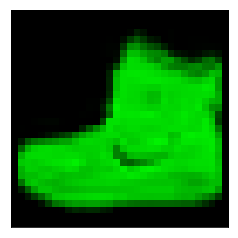

In [30]:
X_train_reshape = np.array(X_train_reshape)


print("X_train shape before: " + str(X_train_s1.shape))
print("X_train shape after: " + str(X_train_reshape.shape))

print("y_train shape before: " + str(y_train_s1.shape))

img_path = X_train_reshape[0]
plt.imshow(img_path)
plt.xticks([])
plt.yticks([])

X_test shape before: (5000, 28, 28)
X_test shape after: (5000, 32, 32, 3)
y_test shape before: (5000, 10)


([], <a list of 0 Text yticklabel objects>)

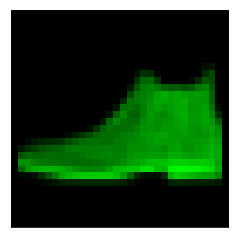

In [31]:
X_test_reshape = np.array(X_test_reshape)
print("X_test shape before: " + str(X_test_s1.shape))
print("X_test shape after: " + str(X_test_reshape.shape))
#y_test = y_test.reshape(10, y_test.shape[0])
print("y_test shape before: " + str(y_test_s1.shape))

img_path = X_test_reshape[0]
plt.imshow(img_path)
plt.xticks([])
plt.yticks([])

In [32]:
# Getting the size of the X_train_reshape and X_test_reshape in MB
from sys import getsizeof
print(getsizeof(X_train_reshape)/1000000)
print(getsizeof(X_test_reshape)/1000000)

737.280144
122.880144


In [33]:
import pickle

# Saving this out for use
with open('X_train_reshape.pickle', 'wb') as file_out:
    pickle.dump(X_train_reshape, file_out)
    file_out.close()

with open('X_test_reshape.pickle', 'wb') as file_out:
    pickle.dump(X_test_reshape, file_out)
    file_out.close()
    
# Saving this out for use
with open('X_train_s1.pickle', 'wb') as file_out:
    pickle.dump(X_train_s1, file_out)
    file_out.close()

with open('X_test_s1.pickle', 'wb') as file_out:
    pickle.dump(X_test_s1, file_out)
    file_out.close()
    
with open('y_train_s1.pickle', 'wb') as file_out:
    pickle.dump(y_train_s1, file_out)
    file_out.close()

with open('y_test_s1.pickle', 'wb') as file_out:
    pickle.dump(y_test_s1, file_out)
    file_out.close()

MemoryError: 

## 3. Fitting data into ResNet50 model

### 3.1 Loading the ResNet50 prebuilt model.

Notes:
- Initializing weights using 'imagenet'.
- Removing Fully Connected layers at the end (include_top=False). This is because the fully connected layers at the end can only take fixed size inputs, which has been previously defined by the input shape and all processing in the convolutional layers. Any change to the input shape will change the shape of the input to the fully connected layers, making the weights incompatible (matrix sizes don't match and cannot be applied).
- Pickle is used for serializing and de-serializing a Python object structure. Any object in python can be pickled so that it can be saved on disk. What pickle does is that it “serialises” the object first before writing it to file. Pickling is a way to convert a python object (list, dict, etc.) into a character stream. The idea is that this character stream contains all the information necessary to reconstruct the object in another python script.

In [35]:
# Firstly let us create an instance of the prebuilt model

from keras.applications import resnet50
ResNet50_prebuilt = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=[32, 32, 3])

C:\Users\mlcur\Anaconda3\envs\Python 3.6\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [36]:
import pickle

# Saving ResNet50_prebuilt model.
with open('ResNet50_prebuilt.pickle', 'wb') as file_out:
    pickle.dump(ResNet50_prebuilt, file_out)
    file_out.close()

### 3.2 Training ResNet50

Note:
- No added Dense layers.
- All ResNet50 layers frozen.

In [ ]:
# Load data (deserialize)
with open('ResNet50_prebuilt.pickle', 'rb') as file_in:
    ResNet50_prebuilt = pickle.load(file_in)
    
# Load data (deserialize)
with open('X_train_reshape.pickle', 'rb') as file_in:
    X_train_reshape = pickle.load(file_in)
    file_in.close()

with open('X_test_reshape.pickle', 'rb') as file_in:
    X_test_reshape = pickle.load(file_in)
    file_in.close()
    
with open('y_train_s1.pickle', 'rb') as file_in:
    y_train_s1 = pickle.load(file_in)
    file_in.close()

with open('y_test_s1.pickle', 'rb') as file_in:
    y_test_s1 = pickle.load(file_in)
    file_in.close()

In [37]:
# Set all the layers to not be trainable (freezing all layers)

for layer in ResNet50_prebuilt.layers[:]:
    layer.trainable = False

In [38]:
# Flatten the ResNet50_prebuilt.output layer so that it is the same shape as the final(prediction) layer.
x = ResNet50_prebuilt.output
x = Flatten()(x)
preds = Dense(10, activation="sigmoid")(x)

In [39]:
from keras.models import Model 
ResNet50_model0 = Model(input=ResNet50_prebuilt.input, outputs=preds)

C:\Users\mlcur\Anaconda3\envs\Python 3.6\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


In [40]:
from keras import optimizers 
ResNet50_model0.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [41]:
import pickle

# Saving this out for use
with open('ResNet50_model0.pickle', 'wb') as file_out:
    pickle.dump(ResNet50_model0, file_out)
    file_out.close()

In [42]:
# Printing the model summary
# ResNet_model0 model has 49 prebuilt layers (ResNet50.output layers) plus 1 final layer added for the output.
ResNet50_model0.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [43]:
# Shows that all ResNet50 prebuilt layers are not trainable.
# Note that the flattened final layer shows as trainable.
for layer in ResNet50_model0.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001D21EEB3EF0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001D21EEB3E10> False
<keras.layers.convolutional.Conv2D object at 0x000001D21EEB3EB8> False
<keras.layers.normalization.BatchNormalization object at 0x000001D21EEE7358> False
<keras.layers.core.Activation object at 0x000001D21EEE72E8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001D21EEE76D8> False
<keras.layers.pooling.MaxPooling2D object at 0x000001D21EEF26D8> False
<keras.layers.convolutional.Conv2D object at 0x000001D21EEF2F60> False
<keras.layers.normalization.BatchNormalization object at 0x000001D21EFEC358> False
<keras.layers.core.Activation object at 0x000001D21EFEC7B8> False
<keras.layers.convolutional.Conv2D object at 0x000001D21F065A20> False
<keras.layers.normalization.BatchNormalization object at 0x000001D21F028DD8> False
<keras.layers.core.Activation object at 0x000001D21F0B4780> False
<keras.layers.convolutional.Conv2D objec

In [44]:
# Printing the shape of the training and  test datasets to ensure that they have the correct shapes.
print (str(X_train_reshape.shape))
print (str(y_train_s1.shape))
print (str(X_test_reshape.shape))
print (str(y_test_s1.shape))

history_ResNet50_model0 = ResNet50_model0.fit(X_train_reshape, y_train_s1, epochs=5,
                    validation_data=(X_test_reshape, y_test_s1),
                   batch_size = 100)

(30000, 32, 32, 3)
(30000, 10)
(5000, 32, 32, 3)
(5000, 10)
Instructions for updating:
Use tf.cast instead.
Train on 30000 samples, validate on 5000 samples
Epoch 1/5
30000/30000 [==============================] - 206s 7ms/step - loss: 0.6874 - acc: 0.6680 - val_loss: 0.5467 - val_acc: 0.6966
Epoch 2/5
30000/30000 [==============================] - 206s 7ms/step - loss: 0.4606 - acc: 0.8171 - val_loss: 0.4608 - val_acc: 0.8621
Epoch 3/5
30000/30000 [==============================] - 210s 7ms/step - loss: 0.4035 - acc: 0.8561 - val_loss: 0.4321 - val_acc: 0.8995
Epoch 4/5
30000/30000 [==============================] - 235s 8ms/step - loss: 0.3724 - acc: 0.8733 - val_loss: 0.4188 - val_acc: 0.9000
Epoch 5/5
30000/30000 [==============================] - 239s 8ms/step - loss: 0.3490 - acc: 0.8830 - val_loss: 0.4120 - val_acc: 0.9000


In [ ]:
# Print the model scores.
score_ResNet50_model0 = ResNet50_model0.evaluate(X_test_reshape, y_test_s1, verbose=0)

print('Test loss:', score_ResNet50_model0[0])
print('Test accuracy:', score_ResNet50_model0[1])

In [ ]:
#----------------------------------------------------
# Saving history details for running ResNet50_model0
#----------------------------------------------------
import pickle

# Saving this out for use
with open('history_ResNet50_model0.pickle', 'wb') as file_out:
    pickle.dump(history_ResNet50_model0, file_out)
    file_out.close()
    
# Load data (deserialize)
with open('history_ResNet50_model0.pickle', 'rb') as file_in:
    history_ResNet50_model0 = pickle.load(file_in)

#----------------------------------------------------
# Saving score details of ResNet50_model0
#----------------------------------------------------
import pickle

# Saving this out for use
with open('score_ResNet50_model0.pickle', 'wb') as file_out:
    pickle.dump(score_ResNet50_model0, file_out)
    file_out.close()
    
# Load data (deserialize)
with open('score_ResNet50_model0.pickle', 'rb') as file_in:
    score_ResNet50_model0 = pickle.load(file_in)

## 4. Adding two dense layers in the Architecture 

In [ ]:
# Load ResNet50_prebuilt model file saved previously.
with open('ResNet50_prebuilt.pickle', 'rb') as file_in:
    ResNet50_prebuilt = pickle.load(file_in)

# Loading the training and test datasets.
with open('X_train_reshape.pickle', 'rb') as file_in:
    X_train_reshape = pickle.load(file_in)
    file_in.close()

with open('X_test_reshape.pickle', 'rb') as file_in:
    X_test_reshape = pickle.load(file_in)
    file_in.close()
    
with open('y_train_s1.pickle', 'rb') as file_in:
    y_train_s1 = pickle.load(file_in)
    file_in.close()

with open('y_test_s1.pickle', 'rb') as file_in:
    y_test_s1 = pickle.load(file_in)
    file_in.close()

In [ ]:
# Set all the layers to not be trainable (freezing all layers)

for layer in ResNet50_prebuilt.layers[:]:
    layer.trainable = False

In [ ]:
# Adding two Dense layers (one with 64 nodes and another with 128) in addition to the ResNet50_prebuilt output layers.
# Flattened the shape output of the Dense layer(128 nodes) so that it is the same shape as the final(prediction) layer.
x = ResNet50_prebuilt.output
x = Dense(64)(x)
x = Activation("relu")(x)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Flatten()(x)

preds = Dense(10, activation="sigmoid")(x)

In [ ]:
from keras.models import Model 
ResNet50_model1 = Model(input=ResNet50_prebuilt.input, outputs=preds)

In [ ]:
from keras import optimizers 
ResNet50_model1.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
import pickle

# Saving this out for use
with open('ResNet50_model1.pickle', 'wb') as file_out:
    pickle.dump(ResNet50_model1, file_out)
    file_out.close()

In [ ]:
ResNet50_model1.summary()

In [ ]:
# Check which layers in the model are trainable.
for layer in ResNet50_model1.layers:
    print(layer, layer.trainable)

In [ ]:
print (str(X_train_reshape.shape))
print (str(y_train_s1.shape))
print (str(X_test_reshape.shape))
print (str(y_test_s1.shape))

history_ResNet50_model1 = ResNet50_model1.fit(X_train_reshape, y_train_s1, epochs=5,
                    validation_data=(X_test_reshape, y_test_s1),
                   batch_size = 100)


In [ ]:
# We can get our score
score_ResNet50_model1 = ResNet50_model1.evaluate(X_test_reshape, y_test_s1, verbose=0)

print('Test loss:', score_ResNet50_model1[0])
print('Test accuracy:', score_ResNet50_model1[1])

In [ ]:
#import pickle
#----------------------------------------------------
# Saving history details for running ResNet50_model0
#----------------------------------------------------
import pickle

# Saving this out for use
with open('history_ResNet50_model1.pickle', 'wb') as file_out:
    pickle.dump(history_ResNet50_model1, file_out)
    file_out.close()
    
# Load data (deserialize)
with open('history_ResNet50_model1.pickle', 'rb') as file_in:
    history_ResNet50_model1 = pickle.load(file_in)

#----------------------------------------------------
# Saving score details of ResNet50_model0
#----------------------------------------------------
import pickle

# Saving this out for use
with open('score_ResNet50_model1.pickle', 'wb') as file_out:
    pickle.dump(score_ResNet50_model1, file_out)
    file_out.close()
    
# Load data (deserialize)
with open('score_ResNet50_model1.pickle', 'rb') as file_in:
    score_ResNet50_model1 = pickle.load(file_in)

## 5.0 Unfreeze  last two layers

In [ ]:
# Load ResNet50_prebuilt model from a saved file.
with open('ResNet50_prebuilt.pickle', 'rb') as file_in:
    ResNet50_prebuilt = pickle.load(file_in)

# Load training and testing dataset from saved files.
with open('X_train_reshape.pickle', 'rb') as file_in:
    X_train_reshape = pickle.load(file_in)
    file_in.close()

with open('X_test_reshape.pickle', 'rb') as file_in:
    X_test_reshape = pickle.load(file_in)
    file_in.close()
    
with open('y_train_s1.pickle', 'rb') as file_in:
    y_train_s1 = pickle.load(file_in)
    file_in.close()

with open('y_test_s1.pickle', 'rb') as file_in:
    y_test_s1 = pickle.load(file_in)
    file_in.close()

In [ ]:
# Set all the layers to not be trainable (freezing all layers)

for layer in ResNet50_prebuilt.layers[:-2]:
    layer.trainable = False

In [ ]:
# Now let us add our dense final layer
x = ResNet50_prebuilt.output
x = Dense(64)(x)
x = Activation("relu")(x)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Flatten()(x)

preds = Dense(10, activation="sigmoid")(x)

In [ ]:
from keras.models import Model 
ResNet50_model2 = Model(input=ResNet50_prebuilt.input, outputs=preds)

In [ ]:
from keras import optimizers 
ResNet50_model2.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
import pickle

# Saving this out for use
with open('ResNet50_model2.pickle', 'wb') as file_out:
    pickle.dump(ResNet50_model2, file_out)
    file_out.close()

In [ ]:
ResNet50_model2.summary()

In [ ]:
for layer in ResNet50_model2.layers:
    print(layer, layer.trainable)

In [ ]:
print (str(X_train_reshape.shape))
print (str(y_train_s1.shape))
print (str(X_test_reshape.shape))
print (str(y_test_s1.shape))

history_ResNet50_model2 = ResNet50_model2.fit(X_train_reshape, y_train_s1, epochs=5,
                    validation_data=(X_test_reshape, y_test_s1),
                   batch_size = 100)

In [ ]:
# We can get our score
score_ResNet50_model2 = ResNet50_model2.evaluate(X_test_reshape, y_test_s1, verbose=0)

print('Test loss:', score_ResNet50_model2[0])
print('Test accuracy:', score_ResNet50_model2[1])

In [ ]:
#import pickle
#----------------------------------------------------
# Saving history details for running ResNet50_model2
#----------------------------------------------------
import pickle

# Saving this out for use
with open('history_ResNet50_model2.pickle', 'wb') as file_out:
    pickle.dump(history_ResNet50_model2, file_out)
    file_out.close()
    
# Load data (deserialize)
with open('history_ResNet50_model2.pickle', 'rb') as file_in:
    history_ResNet50_model2 = pickle.load(file_in)

#----------------------------------------------------
# Saving score details of ResNet50_model0
#----------------------------------------------------
import pickle

# Saving this out for use
with open('score_ResNet50_model2.pickle', 'wb') as file_out:
    pickle.dump(score_ResNet50_model2, file_out)
    file_out.close()
    
# Load data (deserialize)
with open('score_ResNet50_model2.pickle', 'rb') as file_in:
    score_ResNet50_model2 = pickle.load(file_in)

## 4.5 Part 1 Summary

1	BUSINESS UNDERSTANDING
1.1	DATA MINING TASK
1.2	DATASET INFORMATION
1.3	DATA EXPLORATION (TRAINING DATASET)
1.3.1	Summary Statistics 
2	DATA PREPARATION AND TRANSFORMATION
Model Exploration and Evaluation
Summary

# Part 2 - New Model

In [ ]:
# Saving this out for use
with open('X_train_s1.pickle', 'rb') as file_in:
    X_train_s1 = pickle.load(file_in)
    file_in.close()

with open('X_test_s1.pickle', 'rb') as file_in:
    X_test_s1 = pickle.load(file_in)
    file_in.close()
    
with open('y_train_s1.pickle', 'rb') as file_in:
    y_train_s1 = pickle.load(file_in)
    file_in.close()

with open('y_test_s1.pickle', 'rb') as file_in:
    y_test_s1 = pickle.load(file_in)
    file_in.close()
    
print (str(X_train_s1.shape))
print (str(y_train_s1.shape))
print (str(X_test_s1.shape))
print (str(y_test_s1.shape))

In [ ]:
# Using only 2500 images as my computer does not allow more than 4Gb.
X_train_s2 = X_train
y_train_s2 = y_train

X_test_s2 = X_test
y_test_s2 = y_test

In [ ]:
# We need to do some reshaping
import skimage.transform

X_train_reshape2 = []

count = 0

for image in X_train_s2:
    
    # Tracking how many images have been resized.
    count +=1 
    if count % 500 == 0:
        print("Done {} images".format(count))
        
    new_image = skimage.transform.resize(image, (28,28,3), mode='constant')
    X_train_reshape2.append(new_image)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train_reshape2 = np.array(X_train_reshape2)
print("X_train shape before: " + str(X_train_s2.shape))
print("X_train shape after: " + str(X_train_reshape2.shape))

print("y_train shape before: " + str(y_train_s2.shape))

img_path = X_train_reshape2[0]
plt.imshow(img_path)
plt.xticks([])
plt.yticks([])

In [ ]:
# Reshaping testing dataset
X_test_reshape2 = []

count = 0

for image in X_test_s2:
    
    # Tracking how many images have been resized.
    count +=1 
    if count % 500 == 0:
        print("Done {} images".format(count))
        
    new_image = skimage.transform.resize(image, (28, 28,3), mode='constant')
    X_test_reshape2.append(new_image)

In [ ]:
X_test_reshape2 = np.array(X_test_reshape2)
print("X_test shape before: " + str(X_test_s2.shape))
print("X_test shape after: " + str(X_test_reshape2.shape))
#y_test = y_test.reshape(10, y_test.shape[0])
print("y_test shape before: " + str(y_test_s2.shape))

img_path = X_test_reshape2[0]
plt.imshow(img_path)
plt.xticks([])
plt.yticks([])

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", kernel_initializer="he_normal", input_shape=[28, 28, 3]))
model.add(Activation("relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", kernel_initializer="he_normal"))
model.add(Activation("relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", kernel_initializer="he_normal"))
model.add(Activation("relu"))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", kernel_initializer="he_normal"))
model.add(Activation("relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", kernel_initializer="he_normal"))
model.add(Activation("relu"))
model.add(MaxPool2D((2, 2)))

#model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Flatten())
# Sigmoid classifier
model.add(Dense(10))
model.add(Activation("sigmoid"))


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=Adam(), metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history_new_model = model.fit(X_train_reshape2, y_train_s2, epochs=15,
                    validation_data=(X_test_reshape2, y_test_s2),
                   batch_size = 100)

In [ ]:
# We can get our score
score_new_model = model.evaluate(X_test_reshape2, y_test_s2, verbose=0)

print('Test loss:', score_new_model [0])
print('Test accuracy:', score_new_model [1])

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)